_This notebook was written and developed by [Keneth Garcia](https://www.linkedin.com/in/keneth-garcia-a6305b1b9/). Source and license info are on [GitHub](https://github.com/KenethGarcia/ClassiPyGRB)._

# Swift/BAT Data Pre-processing
The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

This notebook summarizes how to preprocess Swift/BAT data at different resolutions. Through this document, we are using the _python3_ implementations from the _ClassiPyGRB_ package. It is necessary to have an internet connection and a _Jupyter Notebook_/_Python 3_ compiler software. The following sections reproduce the method developed by [Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract) to preprocess data.

**REMARK:** As [Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract) said: _"It should be noted that the DFT is not necessarily an optimal preprocessing solution for separating GRBs. Other preprocessing techniques that preserve the information content in the light curve would yield equally valid representations of GRB classes, though possibly not as cleanly separated."_ Please, review the method presented by [Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract), understand the origin and consequences of each step. For more information, see section 2.2 of this work.

First, we need to import the _SWIFT_ instance of _ClassiPyGRB_ to our notebook (and some other packages needed in this notebook):

In [123]:
from ClassiPyGRB import SWIFT
# Packages needed in this notebook
import os
import pandas as pd
import numpy as np

## Changing the Swift GRB binning
There are some cases in which we need to use different data resolutions and binning; handling these situations can be solved in this package by managing the _resolution_ $res$ argument.

Through **ClassiPyGRB**, you can change the _resolution_ variable to $2$, $8$, $16$, $64$, and $256$ ms respectively. Additionally, you can set $res=1000$ for 1s binning and $res=10000$ to use data with a signal-to-noise ratio higher than 5 or 10 s binning (10s data don't have uniform time spacing).

In **ClassiPyGRB**, you have a high level of saving data customization. You can set the following paths:
- $root\_path$ (str): Main path to save data/results from SWIFT. Unique mandatory path to ensure the functionality of SWIFT Class.
- $data\_path$ (str, optional): Path to save data from SWIFT. Defaults to Data folder inside root\_path.
- $original\_data\_path$ (str, optional): Path to save non-manipulated data from SWIFT. Defaults to Original\_Data folder inside data\_path.
- $noise\_data\_path$ (str, optional): Path to save noise-reduced data from SWIFT. Defaults to Noise\_Filtered\_Data folder inside data\_path.
- $results\_path$ (str, optional): Path to save non-manipulated data from SWIFT. Defaults to Results folder inside root\_path.

Moreover, in **ClassiPyGRB**, it is possible to customize the bands used from Swift/BAT data using the parameter `n_bands`. This parameter consists of an array of integers ranging from 1 to 5, where each integer represents a unique band from Swift. In order, 1 represents the 15-25 keV band, 2 represents the 25-50 keV band, 3 represents the 50-100 keV band, 4 represents the 100-350 keV band, and 5 represents the 15-350 keV band. Therefore, for example, by using $n\_bands=[2, 4]$ **ClassiPyGRB** understands that you would like to work with 25-50 keV and 100-350 keV bands. Setting `n_bands` appropriately can help you to improve the preprocessing, results of t-SNE, and custom plotting from Swift/BAT.

However, the most simple and easy implementation of **ClassiPyGRB** only uses $root\_path$ as a main folder and saves both data and results in this path:


In [124]:
swift = SWIFT(root_path='data', res=256, n_bands=[1])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV']


Now, we want to process the data to prepare it for tSNE implementation. This process consists of 4 phases, following ([Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract)):

* Limit all GRBs out of $T_{100}$.
* Normalize light curves (lc) by total fluence in the 15-350keV band.
* Pad with zeros all GRBs, putting them on the same time standard basis.
* Concatenate data from all bands and perform DFT to get the Fourier amplitude spectrum.

In the subsequent sections, we'll describe these processes and show how to use **ClassiPyGRB** to do these steps.

Last, extract the GRB Names from Swift, and remove the GRBs with download errors (this is valid only if you already have downloaded data from Swift/BAT):

In [125]:
df = swift.summary_table()
GRB_names = df['GRBname'] # GRB Names total array
try:
    df = pd.read_table(os.path.join(swift.original_data_path, f"Errors_{swift.end}.txt"), sep='\t', comment='#', names=['GRB Name', 'Error'], header=None)
    GRB_errors = df['GRB Name']
except FileNotFoundError:
    pass
else:
    GRB_names = np.unique(GRB_names[~GRB_names.isin(GRB_errors)])
print(f'There are {len(GRB_names)} GRBs in the current working Swift/BAT dataset.')

There are 1554 GRBs in the current working Swift/BAT dataset.


>[!NOTE]
> If you haven't downloaded the data yet, please check the _BAT_Data_Download_ notebook. It is strongly recommended to download data before running this notebook, although the instances used here can work without any previously downloaded data, the time of pre-processing can be highly affected if you do not have it.

## Data visualization
Let's see how the data looks. You can plot the original light curves for any GRB using the `plot_any_grb` function, specifically, using the argument _t_ in None (indicating that you don't need to filter the LC). In this case, it takes the form (at the resolution selected in the past section):

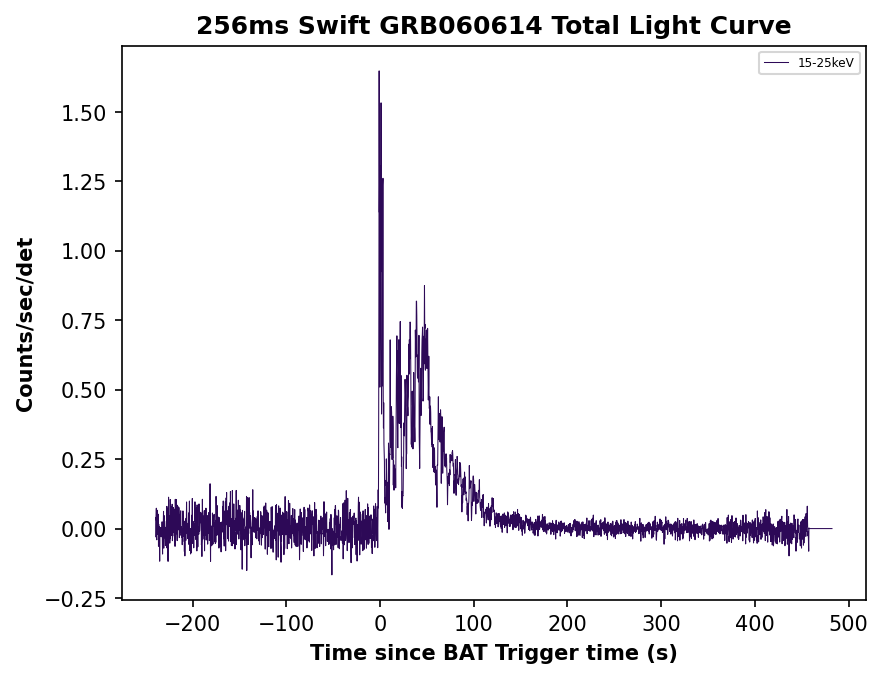

In [126]:
%matplotlib inline
name = 'GRB060614'  # Change this with the GRB of your preference
axis = swift.plot_any_grb(name, t=None, figsize=[6.4, 4.8])

As you can see, there is information in four bands and the cumulative (sum of all bands) in the 15-350keV plot. The x-axis represents the time since BAT Trigger, and the y-axis represents the GRB counts/sec/det.

In the following sections, we are working with the four bands and their total, but to perform non-linear dimensionality reduction, we do not need to use the total band.

## First step: Limit lc out of $T_{100}$
In this step, we need to extract the durations for all GRBs available in `summary_burst_durations.txt` using the `duration_limits` instance. If you don't pass any GRB name to the `duration_limits` instance, this function returns a list containing three values for each GRB in the table: Name, $T_{i}$ start and end times (in seconds), where $i$ can be 50, 90, or 100 (default value), but if you pass it a name, then it returns these values only by this GRB. On the other hand, the function `total_durations` receives a list of GRB names but returns the total duration.

In [127]:
name = 'GRB060614'
durations_times = swift.duration_limits(name=name, t=100)
print(f"{durations_times[0, 0]} has T_100={round(swift.total_durations(names=[name])[0], 3)}s (T_100 start={durations_times[0, 1]}s, T_100 end={durations_times[0, 2]}s)")

Finding Durations: 100%|█████████████████████████| 1/1 [00:05<00:00,  5.30s/GRB]


GRB060614 has T_100=180.576s (T_100 start=-1.496s, T_100 end=179.080s)


With these values, we can limit our GRB light curve (lc) using the instance `lc_limiter`.  In this function, it is possible to directly set the time limiters in seconds or pass it an integer to indicate what duration we need (however, these integers can be only 50, 90, and 100). So, let's try to extract the light curve out of $T_{100}$ by using an integer and setting limits manually, then comparing both:

In [128]:
limited_data_1 = swift.lc_limiter(name)  # Limiting by T_100
limited_data_2 = swift.lc_limiter(name, limits=(durations_times[0, 1], durations_times[0, 2]))  # By values
print(f"Are both arrays equal? Answer={np.array_equal(limited_data_1, limited_data_2)}")
print(limited_data_1)
del limited_data_2  # Delete unused variables to handle memory usage

Are both arrays equal? Answer=True
      Time(s)  15-25keV
931    -1.296  0.853324
932    -1.040  1.646995
933    -0.784  1.138156
934    -0.528  1.305805
935    -0.272  0.509089
936    -0.016  0.740080
937     0.240  1.256466
938     0.496  0.923162
939     0.752  1.061518
940     1.008  1.531977
941     1.264  0.953428
942     1.520  0.412220
943     1.776  0.639725
944     2.032  0.512821
945     2.288  0.547768
946     2.544  0.600462
947     2.800  1.236192
948     3.056  1.260435
949     3.312  0.480030
950     3.568  0.362329
951     3.824  0.452932
952     4.080  0.304492
953     4.336  0.277988
954     4.592  0.240972
955     4.848  0.093740
956     5.104  0.091521
957     5.360  0.110655
958     5.616  0.089496
959     5.872  0.056467
960     6.128  0.173370
961     6.384  0.156025
962     6.640  0.250769
963     6.896  0.199571
964     7.152  0.084832
965     7.408  0.099855
966     7.664  0.166877
967     7.920  0.093338
968     8.176  0.024981
969     8.432  0.065401
970  

Note that both methods are equivalent, and the lc values are now between start and end times for $T_{100}$. Graphically, the lc out of $T_{100}$ is:

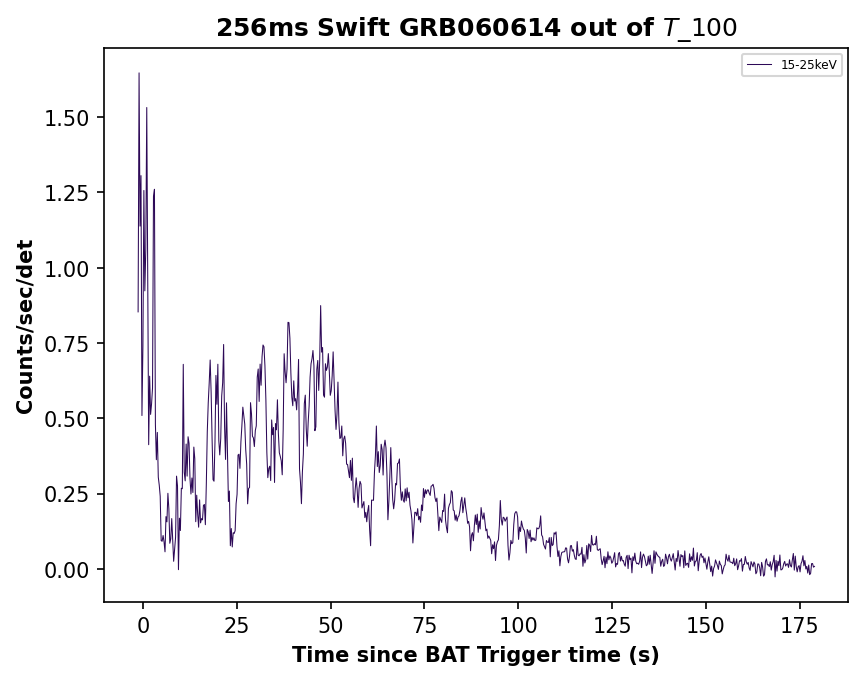

In [129]:
axis_2 = swift.plot_any_grb(name, t=100)  # Plot Light Curve out of T_100

The next step is to do this for all the samples of GRBs, to get a much faster performance of execution, we can use the `parallel_lc_limiter` function:

>[!IMPORTANT]
> The execution time of this function depends entirely on the query time of the data. It is strongly recommended to download on your local computer the data from Swift/BAT and use it locally (see the [download data notebook](https://github.com/KenethGarcia/ClassiPyGRB/blob/4e93f0ea26307a01469e815001d534f4a9a077a9/docs/2.BAT_Data_Download.ipynb)). Otherwise, each one of the workers initialized by **ClassiPyGRB** will query the data directly from Swift/BAT website to limit light curves, and this can take a long time depending on your internet connection and server availability. The following code lines have been executed using a local data folder, but you can change it using the _root_path_ argument in the _SWIFT_ instance.

In [130]:
pd.options.display.max_rows = 4000

In [131]:
limited_data, GRB_names, errors = swift.parallel_lc_limiter(GRB_names)
print(errors)

LC limiting: 100%|█████████████████████████| 1554/1554 [00:42<00:00, 36.15GRB/s]


        Names t_start    t_end       Error
0  GRB041219B                   ValueError
0   GRB050202   0.004    0.132    Length=0
0  GRB050509B     0.0    0.028    Length=0
0   GRB050813  -0.024    0.412    Length=1
0   GRB050906                   ValueError
0   GRB050925  -0.036    0.068    Length=1
0  GRB051105A  -0.004    0.064    Length=1
0   GRB060218                   ValueError
0  GRB060502B  -0.004    0.172    Length=1
0  GRB060510A  -6.752   16.748  Only zeros
0   GRB060728                   ValueError
0   GRB060801    0.04    0.588    Length=2
0   GRB061027                   ValueError
0   GRB061217   0.028    0.284    Length=1
0   GRB061218                   ValueError
0   GRB070126                   ValueError
0   GRB070209     0.0    0.084    Length=1
0  GRB070429B  -0.208    0.328    Length=2
0  GRB070724A  -0.028     0.46    Length=2
0  GRB070810B  -0.008    0.076    Length=0
0   GRB070923  -0.004     0.04    Length=0
0  GRB071112B  -0.048    0.272    Length=1
0   GRB0801

As you see, the function returns a list of limited arrays and errors for all GRBs. In this case, 52 GRBs have any of the following errors:
* _FileNotFoundError_ if GRB does not have any data file downloaded in the selected resolution.
* _ValueError_ if the code can't get any limit values.
* _IndexError_ if the GRB does not appear in the `summary_burst_durations` table.
* _Length={value}_ if the limited GRB data has less than three discrete points.
* _Only zeros_ if the limited GRB data only has zeros.

Additionally, the second argument returned by `parallel_lc_limiter` is a GRB names array indicating the order of results (the first argument returned). This order is now our `GRB_names` variable because it does not have the error names.

To check if the `parallel_lc_limiter` instance is doing its job well, we are going to compare (for the GRB selected before) if the data stored in _limited_data_1_ and obtained in parallelize are equal:

In [132]:
type(limited_data)

list

In [133]:
limited_data[50].shape

(100, 2)

In [134]:
random_index = GRB_names.index(name)  # Search random GRB in new GRB names list
limited_data_random_GRB = limited_data[random_index]  # Extract limited values for random GRB
print(f"Are both arrays equal? Answer={np.array_equal(limited_data_1, limited_data_random_GRB)}")
del limited_data_1 # Delete unused variables to handle memory usage

Are both arrays equal? Answer=True


## Second step: Normalizing Light Curves

To avoid t-SNE being distracted by the fluence value, it is needed to normalize our lc by total time-integrated flux. The `lc_normalize` instance does this job by using the Trapezoid's Rule in any array.

This function receives as input the array to be normalized, and as an optional parameter (`base`), the reference column to normalize (by default, it uses the last column of the array). Using this function, it is possible to normalize any light curve using any Swift/BAT band as a reference. It returns essentially the normalized data array:

In [135]:
normalized_data_random_GRB = swift.lc_normalize(limited_data_random_GRB)
print(normalized_data_random_GRB)
del limited_data_random_GRB # Delete unused variables to handle memory usage

     Time(s)  15-25keV
0     -1.296  0.022127
1     -1.040  0.042706
2     -0.784  0.029512
3     -0.528  0.033859
4     -0.272  0.013201
5     -0.016  0.019190
6      0.240  0.032580
7      0.496  0.023938
8      0.752  0.027525
9      1.008  0.039724
10     1.264  0.024722
11     1.520  0.010689
12     1.776  0.016588
13     2.032  0.013297
14     2.288  0.014204
15     2.544  0.015570
16     2.800  0.032054
17     3.056  0.032683
18     3.312  0.012447
19     3.568  0.009395
20     3.824  0.011744
21     4.080  0.007895
22     4.336  0.007208
23     4.592  0.006248
24     4.848  0.002431
25     5.104  0.002373
26     5.360  0.002869
27     5.616  0.002321
28     5.872  0.001464
29     6.128  0.004495
30     6.384  0.004046
31     6.640  0.006502
32     6.896  0.005175
33     7.152  0.002200
34     7.408  0.002589
35     7.664  0.004327
36     7.920  0.002420
37     8.176  0.000648
38     8.432  0.001696
39     8.688  0.002723
40     8.944  0.007982
41     9.200  0.007145
42     9.45

Note that normalized data are only limited data divided by 15-350 keV integrated flux (in this case). So, the next step is to do this for all limited GRBs. To get a much faster execution performance, we use the `parallelize_lc_normalize` function. To verify if this instance is doing its job well, we will compare (for the random GRB selected before) if the data stored in **_normalized_data_random_GRB_** and obtained in parallelize are equal.

The `parallelize_lc_normalize` function receives an array containing the light curves for each GRB to be normalized. The light curves can be condensed in a Pandas Dataframe (as used in this notebook) or in an array-like (i.e., a numpy array). There is only one requisite to use either `parallelize_lc_normalize` or `lc_normalize`:

- The array's format must follow: $[[t_0, x_0, y_0, z_0, ...], [t_1, x_1, y_1, z_1, ...], [t_2, x_2, y_2, z_2, ...], ...]$ with $t_i$ the time elements, and $x_i$, $y_i$, ... the i-esim bands counts.

In [136]:
normalized_data = swift.parallel_lc_normalize(limited_data)  # Normalizing all light curves
normalized_data_random_GRB_2 = normalized_data[random_index]  # Extract normalized values for random GRB
print(f"Are both arrays equal? Answer={np.allclose(normalized_data_random_GRB, normalized_data_random_GRB_2)}")
del normalized_data_random_GRB_2, limited_data  # Delete unused variables to handle memory usage

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.19/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site.py", line 598, in <module>
Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.19/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site.py", line 598, in <module>


KeyboardInterrupt: 

In [ ]:
print(len(normalized_data))
print(len(normalized_data[0]))
print(len(normalized_data[1]))
print(len(normalized_data[5]))

In [ ]:
limited_data[0]

In [ ]:
normalized_data[0]

In [ ]:
limited_data[0]["15-25keV"]/sum(limited_data[0]["15-25keV"])

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of data points in each spectrum
data_points_counts = [len(spectrum) for spectrum in normalized_data]

In [ ]:
# Plotting the histogram of the number of data points
plt.figure(figsize=(10, 5))
plt.hist(data_points_counts, bins=30, alpha=0.75, color='blue')
plt.title('Histogram of Number of Data Points per Spectrum')
plt.xlabel('Number of Data Points')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Third step: Zero Padding
With all GRBs limited out of $T_{100}$ and normalized, we need to zero-pad their light curves to place them on the same time basis. The `zero_pad` instance performs this job by adding zeros to each column in the input array, and the only arguments required are the final length of the zero-padded array and the array itself.

Here, we are going to see how this function zeros pad the data at its end for the GRB selected before (drawing 10000 rows):

In [ ]:
zero_padded_data_random_GRB = swift.zero_pad(np.asarray(normalized_data_random_GRB), length=10000)
print(zero_padded_data_random_GRB.shape)
del zero_padded_data_random_GRB  # Delete unused variables to handle memory usage

As you can see, now the input array has 1000 columns with zeros added in all the columns. We want to stress that **only when the input is a Pandas Dataframe the time columns will be deleted**. When the input array is, for example, a numpy array, the time column will be returned as well as the Swift/BAT measurements:

In [ ]:
zero_padded_data_random_GRB = swift.zero_pad(normalized_data_random_GRB, length=15309)
print(zero_padded_data_random_GRB)

Now, if you want to iterate over a selected sample of GRBs in a parallel way, you can use the `parallel_zero_pad` instance from **ClassiPyGRB**. It can receive the number of total columns to be used for each GRB as an array, or as an integer the number of columns every GRB will have. By default, the `parallel_zero_pad` looks for the max length of the input arrays and zero pad up to the next optimal length to perform Discrete Fourier Transform (DFT), you can look at [this link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.next_fast_len.html) for further details.

**Note:** Zero-pad arrays will increase the memory usage of **ClassiPyGRB**, take care of your current available memory.

Let's zero pad all the normalized light curves from Swift/BAT to prepare it for DFT (and check if the results are equal from the individual case):

In [ ]:
zero_padded_data = swift.parallel_zero_pad(normalized_data)

In [ ]:
print(len(zero_padded_data[0]))
print(len(zero_padded_data[1]))
print(len(zero_padded_data[100]))
zero_padded_data_random_GRB = swift.zero_pad(normalized_data_random_GRB, length=len(zero_padded_data[0]))
print(f"Are both arrays equal? Answer={np.allclose(zero_padded_data_random_GRB, zero_padded_data[random_index])}")
print(f"Size of zero-padded array: {round(zero_padded_data.__sizeof__()/1024/1024, 5)} MB")

## Intermediate step: Concatenating

To perform Discrete Fourier Transform (DTFT) we need to concatenate the GRB data band by band to get a single signal containing all the zero-padded light curves.

At this point, we want to stress also that DFT is not the best preprocessing solution to separate groups of GRBs, for example, using Stationary Wavelet Transform as stated in [Lána et al.(2022)](https://www.mdpi.com/2075-4434/10/4/78). **ClassiPyGRB** has implemented a DFT approach, but if you want to use another approach, it is possible to only concatenate all the light curves in ascendant order of energy bands (without performing DFT) using the `concatenate` instance and its parallel version `parallel_concatenate`.

The `concatenate` instance receives the input array (either a Pandas Dataframe or any array-like) and joins each column from left to right in a single 1D array. For example, let's concatenate the zero-padded data for the random GRB selected in a Pandas Dataframe and a Numpy array (take care about the time column, if you have not deleted it yet):

In [ ]:
concatenated_example = swift.concatenate(zero_padded_data_random_GRB)  # Pandas Dataframe approach
concatenated_example_2 = swift.concatenate(np.asarray(zero_padded_data_random_GRB))  # Numpy array approach
print(f"Are both arrays equal? Answer={np.allclose(concatenated_example, concatenated_example_2)}. Shape: {concatenated_example.shape}")
print(concatenated_example)
del concatenated_example_2  # Delete unused variables to handle memory usage

On the other hand, the `parallel_concatenate` instance receives a list of arrays with GRB data to be concatenated:

In [ ]:
concatenated_data = swift.parallel_concatenate(zero_padded_data)
print(f"Are both arrays equal? Answer={np.allclose(concatenated_example, concatenated_data[random_index])}")
print(f"Size of zero-padded array: {round(concatenated_data.__sizeof__()/1024/1024, 5)} MB")

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(0, concatenated_example.shape[0], concatenated_example.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(x, concatenated_example, label='Actual Spectrum')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)

>[!NOTE]
> Take care about memory usage when concatenating data! As you can see, the array itself uses GigaBytes in memory.

## Final Step: Discrete Fourier Transform

Finally, the last step of Swift data pre-processing is to perform a Fast Fourier Transform to zero-padded normalized data out of $T_{100}$. There are many Python packages to do this job, particularly in this notebook. Therefore, we use _Numpy_ in the `dft_spectrum` instance, but before that, this function concatenates all energy band measurements in one single array, as required to execute DFT:

In [ ]:
dft_random_GRB = swift.dft_spectrum(concatenated_example)

To plot the DFT of any signal, you can use the `dft_plot` instance. It only needs to receive the Fourier Spectrum as an argument, and it is possible to pass a sequence of Matplotlib axes objects to further customization, and the name of GRB only for enabling title in graphic:

In [ ]:
ax = swift.dft_plot(dft_random_GRB, name=GRB_names[random_index])

In [ ]:
name =  GRB_names[random_index]  # Change this with the GRB of your preference
axis_2 = swift.plot_any_grb(name, t=100)  # Plot Light Curve out of T_100

In [ ]:
axis = swift.plot_any_grb(name, t=None, figsize=[6.4, 4.8])

Note that DFT data is below the Nyquist frequency, following the Nyquist-Shannon sampling theorem:

_The Nyquist-Shannon sampling theorem states that a signal sampled at a rate can be fully reconstructed if it contains only frequency components below half that sampling frequency. Thus, the highest frequency output from the DFT is half the sampling rate._

With this, we can now calculate DFT for the entire zero-padded dataset using the `so_much_fourier` instance:

In [ ]:
pre_processing_data = swift.parallel_dft_spectrum(concatenated_data)
print(f"Are both arrays equal? Answer={np.allclose(dft_random_GRB, pre_processing_data[random_index])}")
print(f"Size of zero-padded array: {round(pre_processing_data.__sizeof__()/1024/1024, 5)} MB")

## Saving results

Finally, the pre-processing data stage is over. Then, we want to save all data in a compressed format to load in the next section. For this, you can use the `save_results` function (based in `savez` instance of Numpy):

In [ ]:
swift.save_results(f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz', names=GRB_names, data=pre_processing_data)  # Save Data with DFT
swift.save_results(f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_False.npz', names=GRB_names, data=concatenated_data)  # Save Data without DFT

In [ ]:
pre_processing_data.shape

In [ ]:
concatenated_data.shape

In [ ]:
pre_processing_data[0]

In [ ]:
r = np.fft.ifft(pre_processing_data[0]).real

In [ ]:
len(r)

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(0, len(r), len(r))
plt.figure(figsize=(10, 6))
plt.plot(x, r, label='Actual Spectrum')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt

y = concatenated_data[0]

x = np.linspace(0, len(y), len(y))
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Actual Spectrum')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt

y = concatenated_data[0][:100]

x = np.linspace(0, len(y), len(y))
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Actual Spectrum')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt

y = r[:100]

x = np.linspace(0, len(y), len(y))
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Actual Spectrum')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)

In [ ]:
import numpy as np

def reconstruct_signal(dft_coefficients):
    # Using np.fft.ifft to compute the inverse Fourier transform
    reconstructed_signal = np.fft.ifft(dft_coefficients)
    return reconstructed_signal.real  # Returning only the real part if the original data was real

# Example usage
og = concatenated_data[0][:100]
dft_coefficients = np.fft.fft(og)  # Example DFT coefficients for demonstration
reconstructed_signal = reconstruct_signal(dft_coefficients)

print("Original signal:", og)
print("Reconstructed signal:", reconstructed_signal)


In [ ]:
x = np.linspace(0, len(og), len(og))
plt.figure(figsize=(10, 6))
plt.plot(x, og, label='Actual Spectrum')  # Converting tensor to numpy array for plotting
plt.plot(x, reconstructed_signal, label='Reconstructed Spectrum',linestyle='--')
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)


In [ ]:
dft_GRB_0 = swift.dft_spectrum(og)
dft_GRB_0

In [ ]:
x = np.linspace(0, len(dft_GRB_0), len(dft_GRB_0))
plt.figure(figsize=(10, 6))
plt.plot(x, dft_GRB_0, label='Actual Spectrum')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)

In [ ]:
dft_coefficients = np.fft.fft(og).real
dft_coefficients

In [ ]:
x = np.linspace(0, len(dft_coefficients), len(dft_coefficients))
plt.figure(figsize=(10, 6))
plt.plot(x, dft_coefficients, label='Actual Spectrum')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)

In [ ]:
dft_coefficients = dft_coefficients[:50]

x = np.linspace(0, len(dft_coefficients), len(dft_coefficients))
plt.figure(figsize=(10, 6))
plt.plot(x, dft_coefficients, label='Actual Spectrum')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)